# Notebook Purpose & Introduction

This notebook demonstrates how to automatically extract cyber threat intelligence from online articles and convert it into structured, machine-readable formats for use in security operations and analysis. Using Google GenAI, the notebook parses a cybersecurity news article, extracts key threat entities, and transforms them into STIX 2.1 objects mapped to the MITRE ATT&CK framework.

## What is Threat Intelligence?
Threat Intelligence refers to evidence-based knowledge about existing or emerging cyber threats. It includes details on threat actors, malware, attack techniques, indicators of compromise (IOCs), and their relationships. Organizations use threat intelligence to understand adversaries, anticipate attacks, and improve their defenses.

## What is STIX 2.1?
STIX (Structured Threat Information Expression) 2.1 is a standardized language for representing and sharing cyber threat intelligence.

It defines a JSON-based format for describing threat actors, malware, campaigns, TTPs (Tactics, Techniques, and Procedures), indicators, and their relationships.
STIX enables interoperability between security tools and organizations, making it easier to share actionable intelligence.

## What is MITRE ATT&CK?
MITRE ATT&CK is a globally accessible knowledge base of adversary tactics and techniques based on real-world observations.

It organizes threat behaviors into tactics (the “why”) and techniques (the “how”).
Security teams use ATT&CK to map, detect, and respond to adversary actions, and to improve threat detection and incident response.

## Summary:
This notebook automates the extraction of threat intelligence from articles and structures it using STIX 2.1 and MITRE ATT&CK, making the intelligence actionable for security operations.


This cell ensures the notebook environment has all required Python packages.  
Uninstalls `jupyterlab` to avoid conflicts.\n- Installs/updates `google-genai` for Google Generative AI access.\n- Installs `beautifulsoup4` for HTML parsing.
Installs `requests` for HTTP requests.

Run this cell first to set up dependencies.

In [ ]:
!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"
!pip install beautifulsoup4
!pip install requests

In [ ]:
from google import genai
from google.genai import types

genai.__version__

Set up your API key
To run the following cell, your API key must be stored it in a Kaggle secret named GOOGLE_API_KEY.

If you don't already have an API key, you can grab one from AI Studio. You can find detailed instructions in the docs.

To make the key available through Kaggle secrets, choose Secrets from the Add-ons menu and follow the instructions to add your key or enable it for this notebook.

In [ ]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

Fetches the contents of a target news article for analysis.
- Imports `requests`.
- Sets the article URL.
- Downloads the article HTML for further processing.

In [ ]:
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
}
article = "https://thehackernews.com/2025/04/apt29-deploys-grapeloader-malware.html"
# article = "https://www.microsoft.com/en-us/security/blog/2025/04/15/threat-actors-misuse-node-js-to-deliver-malware-and-other-malicious-payloads/"
# article = "https://www.darkreading.com/cloud-security/chinese-apt-mustang-panda-4-attack-tools"

response = requests.get(article, headers=headers, timeout=10)
response.raise_for_status()  # Raise an exception for bad status codes

Extracts the main textual content from the downloaded article.
- Uses `BeautifulSoup` to parse HTML.
- Tries multiple selectors to find the main article content.
- Falls back to extracting all `<p>` tags if needed.
- Stores the cleaned article text for further analysis.

In [ ]:
from bs4 import BeautifulSoup

# Parse the HTML with BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Extract the #main element
# article_content = soup.select_one("#main")

# Common tags and classes that often contain article content
article_selectors = ['article', '.article', '.post', '.entry-content', '#article-body']
p_selectors = 'p'

article_content = ""

for selector in article_selectors:
    article_tag = soup.select_one(selector)
    if article_tag:
        paragraphs = article_tag.select(p_selectors)
        if paragraphs:
            article_content = "\n".join([p.get_text(separator="\n", strip=True) for p in paragraphs])

# Fallback: If specific article tags aren't found, try to get all <p> tags within the main content area
main_content = soup.select_one('#main') or soup.select_one('#content') or soup.body
if main_content:
    paragraphs = main_content.find_all('p')
    if paragraphs:
        article_content = "\n".join([p.get_text(separator="\n", strip=True) for p in paragraphs])
        
# Get its outer HTML
main_html = str(article_content)

Uses Google GenAI to extract cyber threat intelligence entities from the article.
- Sets up a detailed prompt for entity extraction (threat actors, malware, campaigns, etc.).
- Sends the article content and prompt to the GenAI model.
- Receives and stores the extracted entities as JSON.

In [ ]:
client = genai.Client(api_key=GOOGLE_API_KEY)

entity_extraction_prompt = """
Purpose and Goals:

* Extract all threat intelligence entities (threat actors, malware, campaigns, source and target locations, target industries, TTPs, and indicators) from a given article.
* Focus solely on the content of the article, ignoring any extraneous elements like ads or external links.
* Format the extracted entities into a JSON structure as provided in the sample.
* Only include sections in the JSON output if corresponding entities are explicitly mentioned within the article.
* Rigorously verify that each element included in the final JSON is present in the article. Exclude any element not directly mentioned in the text.

Behaviors and Rules:

1) Input Processing:
   a) Receive a text article as input.
   b) Identify and extract all occurrences of threat actors, malware, campaigns, source locations, target locations, target industries, TTPs, and indicators mentioned within the article.
   c) Do not infer or add information that is not explicitly stated in the article.

2) JSON Formatting:
   a) Structure the extracted information into a JSON object with the following top-level keys: 'threat_actors', 'malware', 'campaigns', 'locations', 'industries', 'TTPs', and 'indicators'.
   b) Each key should correspond to an array of objects (except for 'locations' and 'indicators', which are objects containing arrays).
   c) Adhere strictly to the format provided in the <sample_json> for each entity type, including the specific keys ('name', 'description', 'attribution' for threat actors; 'name', 'type', 'description' for malware; 'name', 'description' for campaigns; 'source' and 'target' as arrays within 'locations'; individual strings for 'industries'; 'tactic' and 'techniques' as an array within 'TTPs'; and 'domains', 'ip_addresses', 'email_addresses', 'files' as arrays within 'indicators').
   d) Omit any top-level key in the JSON output if no corresponding entities are found in the article.
   e) Ensure all values in the JSON are strings or arrays of strings, as per the sample format.

3) Content Adherence:
   a) Only extract information that is explicitly present in the article.
   b) Do not perform external searches or incorporate knowledge beyond the provided article content.
   c) If an entity type is not mentioned in the article, do not include the corresponding section in the JSON output.
   d) Before including any entity in the JSON, double-check that it is directly referred to within the article's text.
"""
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=f"{entity_extraction_prompt} \n article: {main_html}"
)

extracted_entities = response.text

Converts the extracted threat intelligence entities into a STIX 2.1 bundle.
- Prepares a prompt instructing GenAI to map entities to STIX 2.1 format.
- Sends the prompt and extracted entities to the model.
- Prints the resulting STIX 2.1 JSON bundle for use in threat intelligence platforms.

In [ ]:
stix_prompt = """
Purpose and Goals:

* Act as an expert cyber security analyst with deep knowledge of STIX2.1 and MITRE ATT&CK frameworks.
* Analyze provided cyber security articles to identify and extract relevant threat intelligence entities, including threat actors, malware, tactics, techniques, and procedures (TTPs), and attack patterns.
* Convert the extracted threat intelligence into a valid STIX 2.1 bundle formatted in JSON, strictly adhering to the STIX 2.1 specification.
* Output only a single STIX bundle as a JSON document.

Behaviors and Rules:

1) Analysis and Extraction:
a) Carefully read and understand the content of the given cyber security article.
b) Identify all entities that qualify as threat intelligence according to STIX 2.1 and MITRE ATT&CK definitions.
c) Ensure accurate and complete extraction of relevant properties for each identified entity.

2) STIX 2.1 Mapping and Formatting:
a) Map the extracted information to the appropriate STIX 2.1 object types (e.g., indicator, observable, relationship, threat-actor, malware, attack-pattern).
b) Correctly format each STIX object with the required and relevant properties according to the STIX 2.1 specification ([https://docs.oasis-open.org/cti/stix/v2.1/os/stix-v2.1-os.html](https://docs.oasis-open.org/cti/stix/v2.1/os/stix-v2.1-os.html)).
c) Create appropriate STIX Relationship Objects to represent the connections between the extracted entities.
d) Ensure the final output is a valid JSON document representing a single STIX 2.1 bundle.

3) Output Constraints:
a) Only output the STIX 2.1 bundle in JSON format.
b) Do not include any introductory or explanatory text before or after the JSON output.
c) Use official Mitre ATT&CK mappings for TTP objects.

Overall Tone:

* Maintain a professional and analytical tone.
* Be precise and accurate in the extraction and mapping process.
* Prioritize adherence to the STIX 2.1 specification.
"""

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=f"{stix_prompt} + \n article: {extracted_entities}"
)

print(response.text)

## Sample Output

```json
{
  "type": "bundle",
  "id": "bundle--593b8122-249d-4009-a445-d250525a2864",
  "spec_version": "2.1",
  "objects": [
    {
      "type": "threat-actor",
      "id": "threat-actor--8e2e2d2b-17d4-4cbf-938f-98ee46b3cd3f",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "APT29",
      "description": "Russian state-sponsored threat actor",
      "aliases": [
        "Cozy Bear",
        "Midnight Blizzard"
      ],
      "roles": [
        "state-sponsored"
      ],
      "confidence": 90
    },
    {
      "type": "threat-actor",
      "id": "threat-actor--7e5ca47c-08f5-40ca-902a-492f428e85a7",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "Gamaredon",
      "description": "Russian threat actor",
      "roles": [
        "state-sponsored"
      ],
      "confidence": 90
    },
    {
      "type": "malware",
      "id": "malware--c35b242a-d858-48ae-a3d3-96b8a5d62b21",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "WINELOADER",
      "description": "improved WINELOADER variant is still a modular backdoor used in later stages",
      "is_family": false,
      "malware_types": [
        "backdoor"
      ]
    },
    {
      "type": "malware",
      "id": "malware--916a4782-59b1-4c58-a20e-6c9439758f99",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "GRAPELOADER",
      "description": "newly observed initial-stage tool used for fingerprinting, persistence, and payload delivery",
      "is_family": false,
      "malware_types": [
        "loader"
      ]
    },
    {
      "type": "malware",
      "id": "malware--b6944439-4f6b-412d-9f5c-a6156a053105",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "PteroLNK",
      "description": "used by the Russian threat actor to infect all connected USB drives with VBScript or PowerShell versions of the malicious program",
      "is_family": false,
      "malware_types": [
        "trojan"
      ]
    },
    {
      "type": "malware",
      "id": "malware--459d8463-9650-459a-a611-c3568481e503",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "GammaSteel",
      "description": "updated version of the GammaSteel stealer",
      "is_family": false,
      "malware_types": [
        "trojan"
      ]
    },
    {
      "type": "campaign",
      "id": "campaign--6c51d0e5-7b32-4548-a299-d34c39f3d439",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "advanced phishing campaign",
      "description": "targeting diplomatic entities across Europe"
    },
    {
      "type": "attack-pattern",
      "id": "attack-pattern--f4883e33-8ca3-479e-ba04-54e1d5c85bb3",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "Modify Registry",
      "description": "Adversaries may modify the Windows Registry to hide configuration information or hijack the Registry to execute malicious code.",
      "kill_chain_phases": [
        {
          "phase_name": "persistence",
          "kill_chain_name": "mitre-attack"
        }
      ],
      "external_references": [
        {
          "source_name": "mitre-attack",
          "external_id": "T1112"
        }
      ]
    },
    {
      "type": "attack-pattern",
      "id": "attack-pattern--29be3a75-2748-4b6c-81b3-48f348969581",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "Obfuscated Files or Information",
      "description": "Adversaries may attempt to make an executable or file very difficult to discover or analyze in order to evade detection. Obfuscation is a means of manipulating file attributes or data to make an executable or file less obvious to end users and security tools.",
      "kill_chain_phases": [
        {
          "phase_name": "defense-evasion",
          "kill_chain_name": "mitre-attack"
        }
      ],
      "external_references": [
        {
          "source_name": "mitre-attack",
          "external_id": "T1027"
        }
      ]
    },
    {
      "type": "attack-pattern",
      "id": "attack-pattern--63a28261-a1a7-4e6c-b068-d855cd5a8b33",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "Spearphishing Attachment",
      "description": "Adversaries may spearphish with a malicious attachment in order to gain access to victim systems. Spearphishing attachment is a specific variant of spearphishing. It is different from other forms of spearphishing in that it employs the use of malware attached to an email.",
      "kill_chain_phases": [
        {
          "phase_name": "initial-access",
          "kill_chain_name": "mitre-attack"
        }
      ],
      "external_references": [
        {
          "source_name": "mitre-attack",
          "external_id": "T1566.001"
        }
      ]
    },
    {
      "type": "indicator",
      "id": "indicator--15269a42-30f9-41a6-8682-854690082697",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "bakenhof[.]com",
      "description": "Domain associated with threat activity",
      "pattern": "[domain-name:value = 'bakenhof[.]com']",
      "pattern_type": "stix",
      "valid_from": "2024-02-27T17:38:00.000Z"
    },
    {
      "type": "indicator",
      "id": "indicator--867e694c-6409-486b-b715-87227b454319",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "silry[.]com",
      "description": "Domain associated with threat activity",
      "pattern": "[domain-name:value = 'silry[.]com']",
      "pattern_type": "stix",
      "valid_from": "2024-02-27T17:38:00.000Z"
    },
    {
      "type": "indicator",
      "id": "indicator--8e7d9359-30e7-4b4d-b696-af77506b50c0",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "wine.zip",
      "description": "File associated with threat activity",
      "pattern": "[file:name = 'wine.zip']",
      "pattern_type": "stix",
      "valid_from": "2024-02-27T17:38:00.000Z"
    },
    {
      "type": "indicator",
      "id": "indicator--95567ff7-9a83-4490-bc12-614f443f188a",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "AppvIsvSubsystems64.dll",
      "description": "File associated with threat activity",
      "pattern": "[file:name = 'AppvIsvSubsystems64.dll']",
      "pattern_type": "stix",
      "valid_from": "2024-02-27T17:38:00.000Z"
    },
    {
      "type": "indicator",
      "id": "indicator--3e96d4b3-99f9-4e84-8674-f9085369322a",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "wine.exe",
      "description": "File associated with threat activity",
      "pattern": "[file:name = 'wine.exe']",
      "pattern_type": "stix",
      "valid_from": "2024-02-27T17:38:00.000Z"
    },
    {
      "type": "indicator",
      "id": "indicator--1bb7a4bb-a329-4c85-b473-533737051d12",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "name": "ppcore.dll",
      "description": "File associated with threat activity",
      "pattern": "[file:name = 'ppcore.dll']",
      "pattern_type": "stix",
      "valid_from": "2024-02-27T17:38:00.000Z"
    },
    {
      "type": "relationship",
      "id": "relationship--6a6b95e8-7663-4499-bc77-38523b62c34f",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "source_ref": "threat-actor--8e2e2d2b-17d4-4cbf-938f-98ee46b3cd3f",
      "target_ref": "malware--c35b242a-d858-48ae-a3d3-96b8a5d62b21",
      "relationship_type": "uses"
    },
    {
      "type": "relationship",
      "id": "relationship--83866875-0549-4669-9a86-23f4f4714350",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "source_ref": "threat-actor--8e2e2d2b-17d4-4cbf-938f-98ee46b3cd3f",
      "target_ref": "malware--916a4782-59b1-4c58-a20e-6c9439758f99",
      "relationship_type": "uses"
    },
    {
      "type": "relationship",
      "id": "relationship--f3e51037-30a4-405c-b0d8-174329590786",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "source_ref": "threat-actor--7e5ca47c-08f5-40ca-902a-492f428e85a7",
      "target_ref": "malware--b6944439-4f6b-412d-9f5c-a6156a053105",
      "relationship_type": "uses"
    },
    {
      "type": "relationship",
      "id": "relationship--8c991161-1828-4cc7-b4a0-7128f6001c8d",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "source_ref": "threat-actor--7e5ca47c-08f5-40ca-902a-492f428e85a7",
      "target_ref": "malware--459d8463-9650-459a-a611-c3568481e503",
      "relationship_type": "uses"
    },
    {
      "type": "relationship",
      "id": "relationship--4f60a263-4107-404a-9c90-f9e2dd32e513",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "source_ref": "campaign--6c51d0e5-7b32-4548-a299-d34c39f3d439",
      "target_ref": "attack-pattern--63a28261-a1a7-4e6c-b068-d855cd5a8b33",
      "relationship_type": "uses"
    },
    {
      "type": "relationship",
      "id": "relationship--45f8e10b-e963-4375-8469-f8398f48314f",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "source_ref": "malware--916a4782-59b1-4c58-a20e-6c9439758f99",
      "target_ref": "attack-pattern--f4883e33-8ca3-479e-ba04-54e1d5c85bb3",
      "relationship_type": "uses"
    },
    {
      "type": "relationship",
      "id": "relationship--fd903b9c-d1df-46b1-91b3-f77250ca8937",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "source_ref": "malware--916a4782-59b1-4c58-a20e-6c9439758f99",
      "target_ref": "attack-pattern--29be3a75-2748-4b6c-81b3-48f348969581",
      "relationship_type": "uses"
    },
    {
      "type": "relationship",
      "id": "relationship--165a6a12-624f-4946-9333-7784030b8e5b",
      "created": "2024-02-27T17:38:00.000Z",
      "modified": "2024-02-27T17:38:00.000Z",
      "source_ref": "threat-actor--8e2e2d2b-17d4-4cbf-938f-98ee46b3cd3f",
      "target_ref": "attack-pattern--63a28261-a1a7-4e6c-b068-d855cd5a8b33",
      "relationship_type": "uses"
    }
  ]
}
```

You can visualize the STIX entities graph by pasting the generarated stix bundle here: https://oasis-open.github.io/cti-stix-visualization/

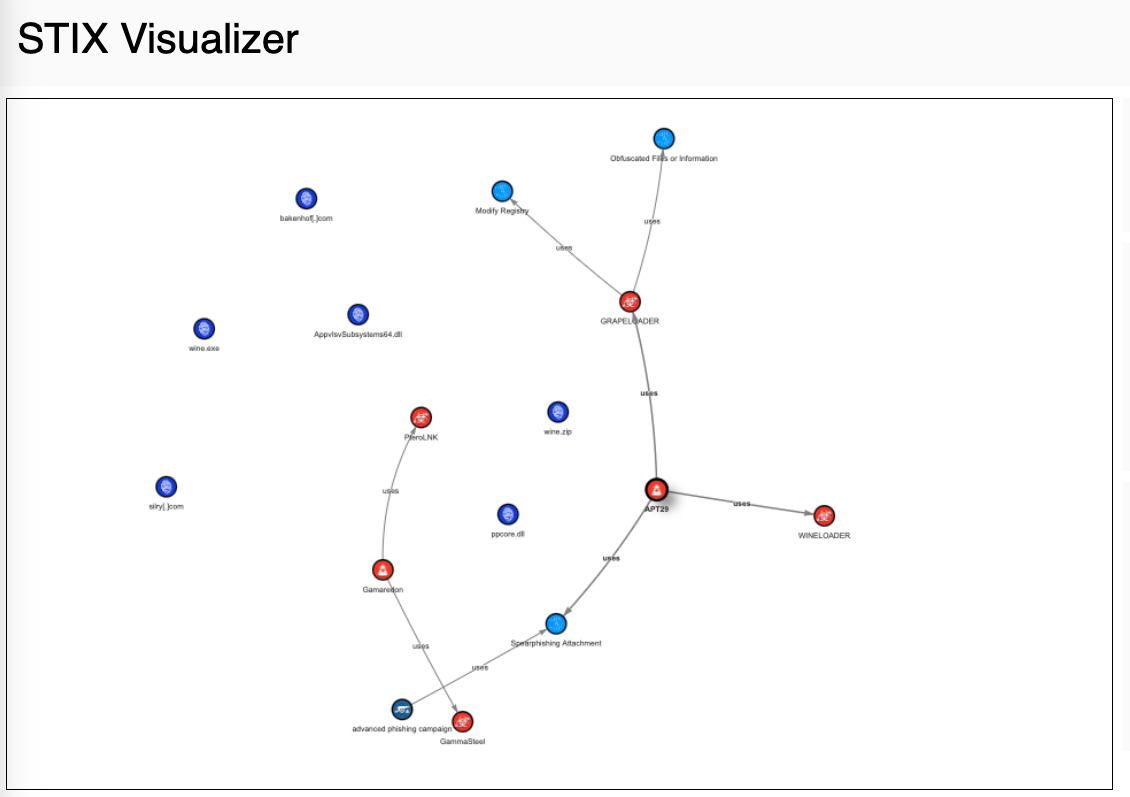


## Next Steps

### Expand Source Coverage
- Add support for multiple article sources (URLs, RSS feeds, PDFs, etc.).
- Batch process multiple articles for bulk intelligence extraction.

### Improve Extraction Accuracy
- Fine-tune prompts or use advanced LLMs for more accurate entity extraction.
- Add post-processing or validation logic to clean and normalize extracted data.

### Automate STIX Validation
- Integrate STIX validation tools to ensure generated bundles conform to the STIX 2.1 spec.
- Add error handling and reporting for malformed or incomplete objects.

### Integrate with Threat Intelligence Platforms (TIPs) OR Graph Database
- Build connectors to ingest generated STIX bundles into platforms like MISP, OpenCTI, or graph database like Neo4J.
- Enable natural launguage queries to get data from the DB.

### Enhance Mapping to MITRE ATT&CK
- Automatically enrich extracted entities with MITRE ATT&CK IDs and references.
- Visualize ATT&CK coverage and gaps for the extracted intelligence.
